## When is the best time of day to ride BART?

Riders with flexible commutes can time their commutes to ride BART at the most convenient time

Factors that influence how good of a time it is:
- how close is the time to the rider's ideal commute time?
- how crowded are the train cars?
- how frequent are the trains?
- how crowded are the stations?
- how much crime is there typically at that time?

That differ between riders:
- what are this rider's priorities between the above factors?
- where is this rider commuting from and to?
- 

### Prior art
- https://medium.com/@ALLrambles/a-guide-to-riding-bart-for-people-who-hate-crowds-ecdb6df12fa7
- https://www.kaggle.com/jonathanbouchet/bart-transit-system/data

### Exploring data sources
- monthly reports (https://www.bart.gov/about/reports/ridership) aren't helpful because they don't include time of day (example: https://docs.google.com/spreadsheets/d/1EYyXRwhvgq9vaQeequK7b5gQahnQq0QwSkfvvo5VQ8w/edit#gid=1814715031)
- seems like the only real option is the daily reports: http://64.111.127.166/origin-destination/
- seems like the API is the best source re: when trains come and how long they are: https://api.bart.gov/docs/overview/index.aspx
    - AFAICT only the real-time departures API includes train length i.e. "length": https://api.bart.gov/docs/etd/etd.aspx
    - looks like there's no way to get past or future data
    - the schedule API provides info for the whole day but doesn't include car length: https://api.bart.gov/docs/sched/index.aspx. Looks like I'd want to use:
        - route schedule: https://api.bart.gov/docs/sched/routesched.aspx or
        - station schedule: https://api.bart.gov/docs/sched/stnsched.aspx

### Starting analysis
#### Ridership per hour on weekdays

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

five_days = pd.read_csv('processed_data/five_days.csv')
five_days['Day'] = pd.to_datetime(five_days['Day'])

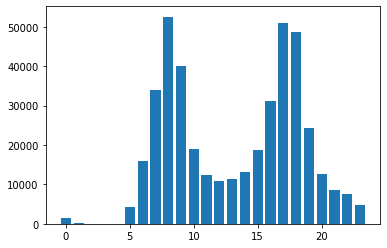

In [2]:
hours = range(24)

weekdays_data = five_days[five_days['Day'].dt.dayofweek < 5]

number_of_days = len(weekdays_data.drop_duplicates(subset='Day'))

dfs_by_hour = [weekdays_data[weekdays_data['Hour'] == hour] for hour in hours]

riders_per_hour = [df_by_hour["Trip Count"].sum() for df_by_hour in dfs_by_hour]

riders_per_hour_per_day = [riders/number_of_days for riders in riders_per_hour]

plt.bar(hours, riders_per_hour_per_day)
plt.show()

TODO:
- better axis labels
    - what exactly do the buckets in the data even refer to?
    
#### Approx trains per hour through Embarcadero

Very handwavy. Major problems:
- is Embarcadero what we care about the most? I guess all East Bay <> SF trains go through, so that's a good proxy for something
- times are when the train leaves its starting station (I think), not when it goes through Embarcadero
- don't know number of cars per train, need real-time data for that

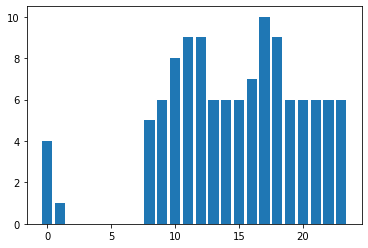

In [3]:
weekday_trains_through_embr = pd.read_csv('processed_data/08-11-2019-embr-sched.csv')
weekday_trains_through_embr['@origTime'] = pd.to_datetime(weekday_trains_through_embr['@origTime'])

trains_by_hours = [weekday_trains_through_embr[weekday_trains_through_embr['@origTime'].dt.hour == hour] for hour in hours]
trains_per_hour = [len(trains_by_hour) for trains_by_hour in trains_by_hours]
plt.bar(hours, trains_per_hour)
plt.show()

#### Approx riders per train per hour through embr

Rather exciting because it's actually an approximation of the thing I want: riders per car

Major problems not covered above:
- pretty sure that the data are off from each other by an hour, which makes things a bit weird

/Users/brachbach/.local/share/virtualenvs/BART_analysis-DmraOYr2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


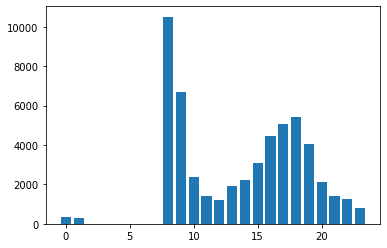

In [4]:
riders_per_train_per_hour = [riders/trains_per_hour[i] for (i,riders) in enumerate(riders_per_hour_per_day)]
plt.bar(hours, riders_per_train_per_hour)
plt.show()

Features that could eventually be cool:
- you give your preferences, app tells you when would be best for you to commute
- interactive graphs -- you specify where you're going from/to, everything adjusts to that
- 